In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [11]:
DF = pd.read_csv('data/atp_matches_features_balanced.csv')

In [12]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Dict

from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

import joblib
import warnings
warnings.filterwarnings("ignore")


In [13]:
# Partindo do DF já carregado no seu ambiente.
assert 'winner' in DF.columns, "DF precisa ter a coluna 'winner'"

# Colunas que não devem entrar no modelo-base (potencial vazamento/memorization)
ID_COLS = ['player1_id', 'player2_id']

# Todas as diferenciais + meta
TARGET = 'winner'
feature_cols = [c for c in DF.columns if c not in ID_COLS + [TARGET]]

# Checagens rápidas
print("Shape:", DF.shape)
print("Target balance:", DF[TARGET].value_counts(normalize=True).round(3).to_dict())
print("Exemplo de features:", feature_cols[:10])

# Drop de linhas com NaN nas features/target (ou troque por imputação se necessário)
data = DF[feature_cols + [TARGET]].dropna().copy()
X = data[feature_cols]
y = data[TARGET].astype(int)


Shape: (95375, 54)
Target balance: {1: 0.5, 0: 0.5}
Exemplo de features: ['best_of', 'draw_size', 'atp_points_differential', 'atp_rank_differential', 'age_differential', 'ht_differential', 'elo_differential', 'h2h_differential', 'h2h_surface_differential', 'p_ace_last3_differential']


In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [15]:
def build_matchup_groups(df: pd.DataFrame) -> np.ndarray:
    # agrupa por par não ordenado de jogadores (confronto)
    return df[['player1_id','player2_id']].apply(
        lambda r: tuple(sorted((r['player1_id'], r['player2_id']))), axis=1
    ).astype(str).values

groups = build_matchup_groups(DF.loc[data.index, :])
gcv = GroupKFold(n_splits=5)
# use 'gcv.split(X, y, groups=groups)' em vez de 'cv.split(X, y)'


In [16]:
def evaluate_cv(model: Pipeline, X: pd.DataFrame, y: pd.Series, splitter, groups=None, plot_calibration=False, title=""):
    aucs, logs, accs, briers = [], [], [], []
    prob_all, y_all = [], []

    for fold, (tr, te) in enumerate(splitter.split(X, y, groups) if groups is not None else splitter.split(X, y), 1):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]

        model.fit(Xtr, ytr)
        proba = model.predict_proba(Xte)[:,1]
        pred  = (proba >= 0.5).astype(int)

        aucs.append(roc_auc_score(yte, proba))
        logs.append(log_loss(yte, proba, labels=[0,1]))
        accs.append(accuracy_score(yte, pred))
        briers.append(brier_score_loss(yte, proba))

        prob_all.append(proba)
        y_all.append(yte.values)

        print(f"Fold {fold} | AUC={aucs[-1]:.3f}  LogLoss={logs[-1]:.3f}  Acc={accs[-1]:.3f}  Brier={briers[-1]:.3f}")

    prob_all = np.concatenate(prob_all)
    y_all = np.concatenate(y_all)

    print(f"\n[{title}] MÉDIAS  | AUC={np.mean(aucs):.3f}±{np.std(aucs):.3f} | LogLoss={np.mean(logs):.3f} "
          f"| Acc={np.mean(accs):.3f} | Brier={np.mean(briers):.3f}")

    if plot_calibration:
        plt.figure()
        CalibrationDisplay.from_predictions(y_all, prob_all, n_bins=10)
        plt.title(f"Calibration Curve – {title}")
        plt.show()

    return {
        "auc": np.mean(aucs),
        "logloss": np.mean(logs),
        "acc": np.mean(accs),
        "brier": np.mean(briers)
    }


In [17]:
# Baseline (chuta classe majoritária): referência mínima
dummy = DummyClassifier(strategy="most_frequent")

# Transformador numérico (scaling) – útil para modelos lineares
num_transform = ColumnTransformer([
    ("scaler", StandardScaler(with_mean=True, with_std=True), feature_cols)
], remainder="drop")

# Logistic Regression (com classe balanceada)
logreg = Pipeline([
    ("prep", num_transform),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Random Forest
rf = Pipeline([
    ("prep", "passthrough"),  # árvores não precisam de scaling
    ("clf", RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_leaf=10,
        class_weight="balanced_subsample", random_state=42, n_jobs=-1
    ))
])

# HistGradientBoosting (rápido, lida bem com não linearidades)
hgb = Pipeline([
    ("prep", "passthrough"),
    ("clf", HistGradientBoostingClassifier(
        max_depth=None, learning_rate=0.05, max_iter=500,
        l2_regularization=0.0, random_state=42
    ))
])



=== Dummy ===
Fold 1 | AUC=0.500  LogLoss=18.009  Acc=0.500  Brier=0.500
Fold 2 | AUC=0.500  LogLoss=18.011  Acc=0.500  Brier=0.500
Fold 3 | AUC=0.500  LogLoss=18.010  Acc=0.500  Brier=0.500
Fold 4 | AUC=0.500  LogLoss=18.010  Acc=0.500  Brier=0.500
Fold 5 | AUC=0.500  LogLoss=18.010  Acc=0.500  Brier=0.500

[Dummy] MÉDIAS  | AUC=0.500±0.000 | LogLoss=18.010 | Acc=0.500 | Brier=0.500

=== Logistic Regression ===
Fold 1 | AUC=0.732  LogLoss=0.604  Acc=0.667  Brier=0.209
Fold 2 | AUC=0.725  LogLoss=0.610  Acc=0.660  Brier=0.211
Fold 3 | AUC=0.734  LogLoss=0.603  Acc=0.672  Brier=0.208
Fold 4 | AUC=0.723  LogLoss=0.610  Acc=0.658  Brier=0.212
Fold 5 | AUC=0.724  LogLoss=0.610  Acc=0.660  Brier=0.212

[LogReg] MÉDIAS  | AUC=0.728±0.005 | LogLoss=0.607 | Acc=0.663 | Brier=0.210


<Figure size 640x480 with 0 Axes>

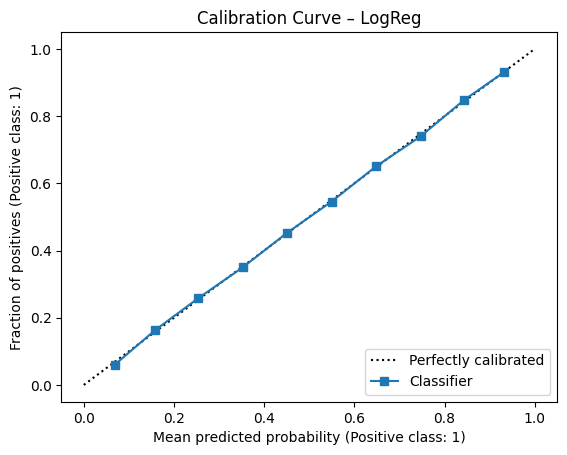


=== Random Forest ===
Fold 1 | AUC=0.727  LogLoss=0.609  Acc=0.664  Brier=0.211
Fold 2 | AUC=0.719  LogLoss=0.613  Acc=0.654  Brier=0.213
Fold 3 | AUC=0.729  LogLoss=0.608  Acc=0.667  Brier=0.210
Fold 4 | AUC=0.719  LogLoss=0.614  Acc=0.654  Brier=0.213
Fold 5 | AUC=0.720  LogLoss=0.613  Acc=0.657  Brier=0.213

[RF] MÉDIAS  | AUC=0.723±0.004 | LogLoss=0.612 | Acc=0.659 | Brier=0.212


<Figure size 640x480 with 0 Axes>

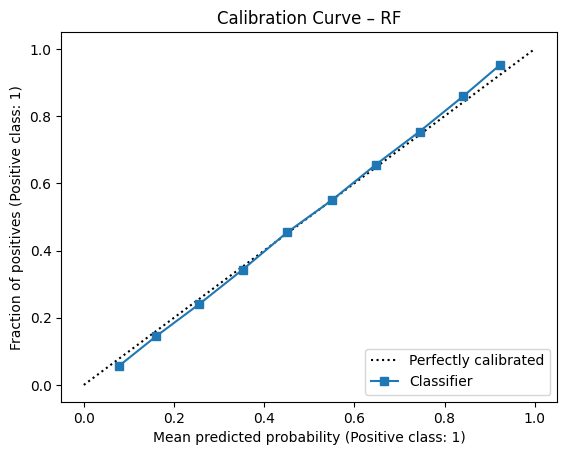


=== HistGradientBoosting ===
Fold 1 | AUC=0.730  LogLoss=0.606  Acc=0.662  Brier=0.210
Fold 2 | AUC=0.723  LogLoss=0.610  Acc=0.656  Brier=0.212
Fold 3 | AUC=0.735  LogLoss=0.603  Acc=0.672  Brier=0.208
Fold 4 | AUC=0.722  LogLoss=0.611  Acc=0.658  Brier=0.212
Fold 5 | AUC=0.722  LogLoss=0.610  Acc=0.658  Brier=0.212

[HGB] MÉDIAS  | AUC=0.726±0.005 | LogLoss=0.608 | Acc=0.661 | Brier=0.211


<Figure size 640x480 with 0 Axes>

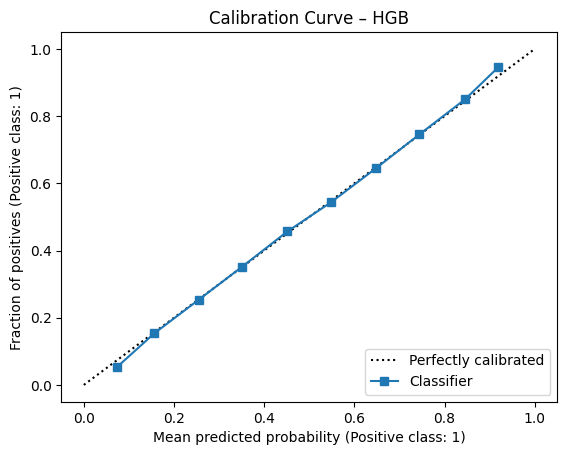

In [18]:
print("\n=== Dummy ===")
_ = evaluate_cv(dummy, X, y, cv, title="Dummy", plot_calibration=False)

print("\n=== Logistic Regression ===")
res_log = evaluate_cv(logreg, X, y, cv, title="LogReg", plot_calibration=True)

print("\n=== Random Forest ===")
res_rf = evaluate_cv(rf, X, y, cv, title="RF", plot_calibration=True)

print("\n=== HistGradientBoosting ===")
res_hgb = evaluate_cv(hgb, X, y, cv, title="HGB", plot_calibration=True)


In [19]:
param_dist_hgb = {
    "clf__learning_rate":  np.logspace(-2.5, -0.5, 20),
    "clf__max_iter":       [200, 400, 600, 800],
    "clf__max_depth":      [None, 3, 5, 7, 9],
    "clf__l2_regularization": np.logspace(-4, 1, 10),
    "clf__min_samples_leaf": [10, 20, 50, 100]
}

hgb_base = Pipeline([("prep","passthrough"), ("clf", HistGradientBoostingClassifier(random_state=42))])

search = RandomizedSearchCV(
    estimator=hgb_base,
    param_distributions=param_dist_hgb,
    n_iter=60,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)
print("Melhor AUC (CV):", search.best_score_)
print("Melhores params:", search.best_params_)
best_hgb = search.best_estimator_


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Melhor AUC (CV): 0.7266004041686516
Melhores params: {'clf__min_samples_leaf': 50, 'clf__max_iter': 800, 'clf__max_depth': 3, 'clf__learning_rate': np.float64(0.017252105499420408), 'clf__l2_regularization': np.float64(0.004641588833612782)}


                           feature  importance_mean  importance_std
6                 elo_differential         0.130769        0.001814
4                 age_differential         0.008833        0.000267
3            atp_rank_differential         0.005051        0.000283
43    elo_gradient_50_differential         0.002051        0.000123
2          atp_points_differential         0.001833        0.000268
12    p_1st_won_last3_differential         0.001755        0.000119
8         h2h_surface_differential         0.001180        0.000070
19    p_1st_won_last5_differential         0.000606        0.000054
11     p_1st_in_last3_differential         0.000588        0.000073
26   p_1st_won_last10_differential         0.000570        0.000059
20    p_2nd_won_last5_differential         0.000568        0.000077
27   p_2nd_won_last10_differential         0.000547        0.000063
13    p_2nd_won_last3_differential         0.000464        0.000046
50   elo_gradient_100_differential         0.000

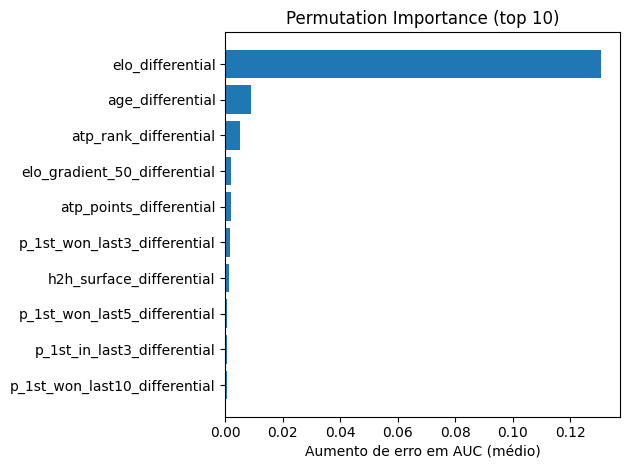

<Figure size 640x480 with 0 Axes>

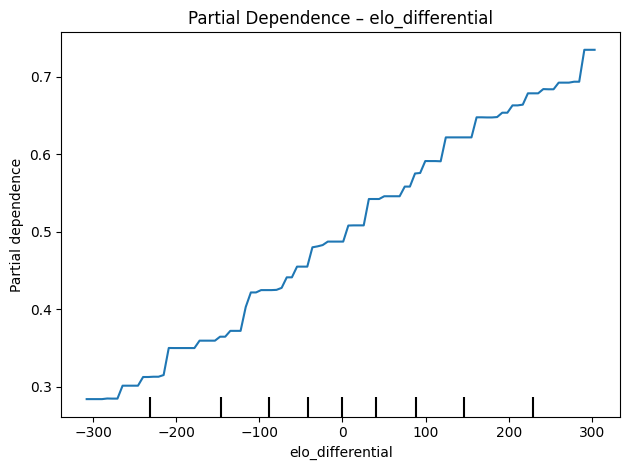

<Figure size 640x480 with 0 Axes>

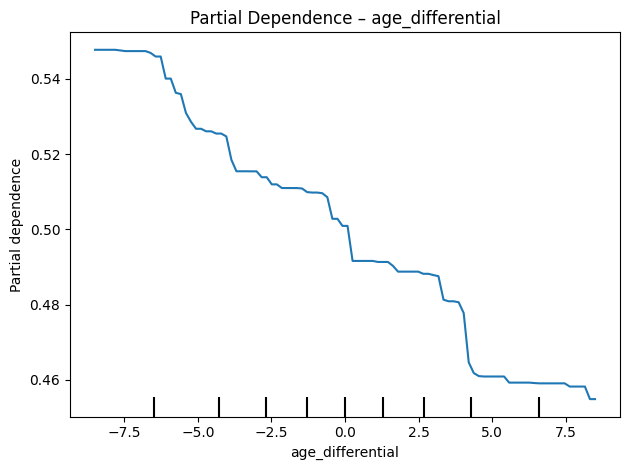

<Figure size 640x480 with 0 Axes>

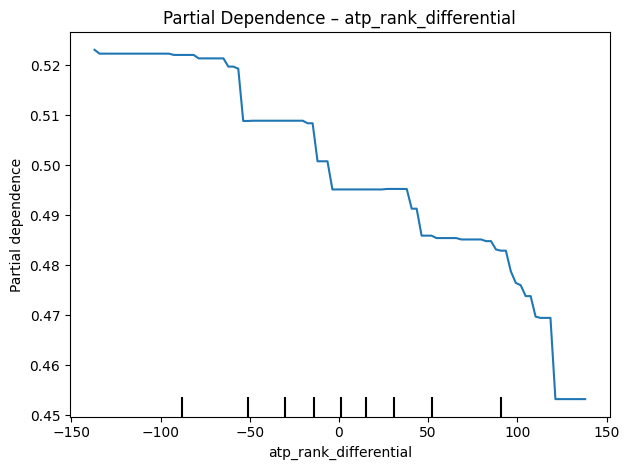

In [20]:
# Fit final em todo o dataset (ou, melhor, use um hold-out final se tiver tamanho suficiente)
best_model = best_hgb  # ou hgb / rf / logreg
best_model.fit(X, y)

# Permutation Importance
r = permutation_importance(best_model, X, y, scoring="roc_auc", n_repeats=15, random_state=42, n_jobs=-1)
perm_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)
print(perm_imp.head(20))

# Plot: top 10
top10 = perm_imp.head(10).iloc[::-1]
plt.figure()
plt.barh(top10["feature"], top10["importance_mean"])
plt.title("Permutation Importance (top 10)")
plt.xlabel("Aumento de erro em AUC (médio)")
plt.tight_layout()
plt.show()

# Partial Dependence das 3 mais importantes (se forem contínuas)
top3 = perm_imp["feature"].head(3).tolist()
for feat in top3:
    plt.figure()
    try:
        PartialDependenceDisplay.from_estimator(best_model, X, [feat], kind="average")
        plt.title(f"Partial Dependence – {feat}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Não foi possível PDP de {feat}: {e}")


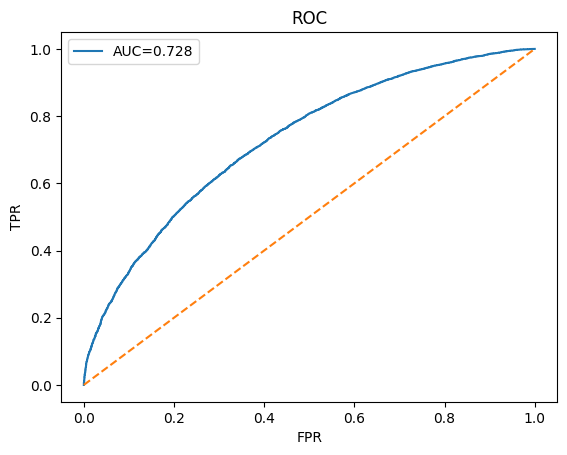

<Figure size 640x480 with 0 Axes>

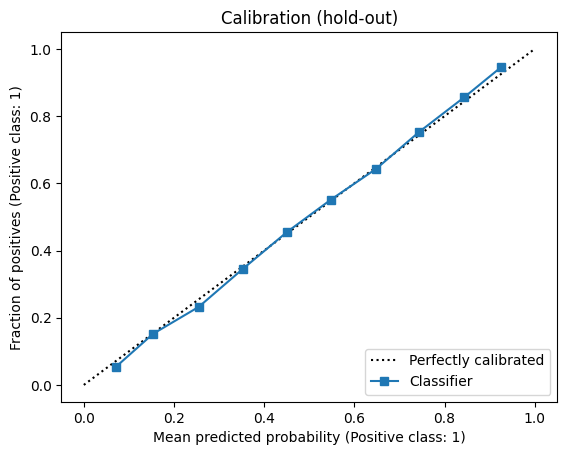

In [21]:
# split final para ilustração de curvas
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)
best_model.fit(X_tr, y_tr)
proba = best_model.predict_proba(X_te)[:,1]

# ROC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_te, proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_te, proba):.3f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# Calibration
plt.figure()
CalibrationDisplay.from_predictions(y_te, proba, n_bins=10)
plt.title("Calibration (hold-out)")
plt.show()


In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoding simples para IDs com smoothing."""
    def __init__(self, cols: List[str], min_samples: int = 20, smoothing: float = 10.0):
        self.cols = cols
        self.min_samples = min_samples
        self.smoothing = smoothing
        self.global_mean_ = None
        self.maps_ = {}

    def fit(self, X, y):
        df = X.copy()
        df["_y"] = y.values
        self.global_mean_ = df["_y"].mean()
        self.maps_ = {}
        for c in self.cols:
            stats = df.groupby(c)["_y"].agg(["mean","count"])
            smooth = (stats["count"] * stats["mean"] + self.smoothing * self.global_mean_) / (stats["count"] + self.smoothing)
            self.maps_[c] = smooth.to_dict()
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            X[f"{c}_te"] = X[c].map(self.maps_[c]).fillna(self.global_mean_)
        return X.drop(columns=self.cols)

# Exemplo de uso em nested CV:
all_cols = ID_COLS + feature_cols
X_all = DF[all_cols].dropna()
y_all = DF.loc[X_all.index, TARGET].astype(int)

outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipe_te_hgb = Pipeline([
    ("te", TargetEncoder(cols=ID_COLS, min_samples=20, smoothing=20.0)),
    ("clf", HistGradientBoostingClassifier(random_state=42))
])

param_dist_te = {
    "clf__learning_rate":  np.logspace(-2.5, -0.5, 12),
    "clf__max_iter":       [300, 600, 900],
    "clf__max_depth":      [None, 3, 5, 7],
    "clf__l2_regularization": np.logspace(-4, 1, 8),
    "clf__min_samples_leaf": [10, 20, 50]
}

outer_scores = []
for tr_idx, te_idx in outer.split(X_all, y_all):
    Xtr, Xte = X_all.iloc[tr_idx], X_all.iloc[te_idx]
    ytr, yte = y_all.iloc[tr_idx], y_all.iloc[te_idx]

    search_te = RandomizedSearchCV(
        pipe_te_hgb, param_dist_te, n_iter=40, scoring="roc_auc",
        cv=inner, random_state=42, n_jobs=-1
    )
    search_te.fit(Xtr, ytr)
    proba = search_te.best_estimator_.predict_proba(Xte)[:,1]
    outer_scores.append(roc_auc_score(yte, proba))
    print(f"Outer AUC: {outer_scores[-1]:.3f} | best params: {search_te.best_params_}")

print("Nested TE-HGB AUC médio:", np.mean(outer_scores))


Outer AUC: 0.725 | best params: {'clf__min_samples_leaf': 50, 'clf__max_iter': 900, 'clf__max_depth': 3, 'clf__learning_rate': np.float64(0.011103363181676379), 'clf__l2_regularization': np.float64(0.013894954943731374)}
Outer AUC: 0.723 | best params: {'clf__min_samples_leaf': 50, 'clf__max_iter': 900, 'clf__max_depth': 3, 'clf__learning_rate': np.float64(0.011103363181676379), 'clf__l2_regularization': np.float64(0.013894954943731374)}
Outer AUC: 0.730 | best params: {'clf__min_samples_leaf': 50, 'clf__max_iter': 900, 'clf__max_depth': 3, 'clf__learning_rate': np.float64(0.011103363181676379), 'clf__l2_regularization': np.float64(0.013894954943731374)}
Outer AUC: 0.720 | best params: {'clf__min_samples_leaf': 50, 'clf__max_iter': 900, 'clf__max_depth': 3, 'clf__learning_rate': np.float64(0.011103363181676379), 'clf__l2_regularization': np.float64(0.013894954943731374)}
Outer AUC: 0.718 | best params: {'clf__min_samples_leaf': 50, 'clf__max_iter': 900, 'clf__max_depth': 3, 'clf__learn

In [23]:
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(exist_ok=True)
joblib.dump(best_model, MODELS_DIR / "tennis_winner_model.joblib")
perm_imp.to_csv(MODELS_DIR / "permutation_importance.csv", index=False)


In [24]:
def predict_match(model, row: Dict[str, float]) -> Dict[str, float]:
    """row deve conter o mesmo conjunto de features do treinamento."""
    x = pd.DataFrame([row])[feature_cols]
    proba = model.predict_proba(x)[:,1][0]
    pred = int(proba >= 0.5)
    return {"prob_player1_wins": float(proba), "pred_winner": pred}

# exemplo:
# sample = X.iloc[0].to_dict()
# predict_match(best_model, sample)


In [31]:

sample = X.iloc[10].to_dict()
predict_match(best_model, sample)


{'prob_player1_wins': 0.5359415569377535, 'pred_winner': 1}